### Fisier in care se afla implementarea algoritmului SAT folosind quantum computing

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService 

Adaug contul de ibm in environment pentru a-l putea folosi ca sa testez algoritmul folosind serviciul lor de cloud. 

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the token from the environment variable
api_token = os.getenv("IBM_QUANTUM_TOKEN")

if not api_token:
    raise ValueError("IBM_QUANTUM_TOKEN not found in .env file. Please add it.")

# Save the account using the token from the .env file
service = QiskitRuntimeService.save_account(
    token=api_token,
    instance="PracticaVara",
    region="us-east",
    set_as_default=True,
)

print("Qiskit Runtime Service account saved successfully.")

Afisez backend-urile disponibile ca sa stiu pe care pot sa-l apelez si e disponibil, argumentul simulator=False inseamna ca in cazul in care serviciul nu e disponibil sa nu foloseasca simulatorul.


In [6]:
service = QiskitRuntimeService()
backends = service.backends(simulator=False)
print(backends)
backend = backends[0]

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


#### Exemplu de implementare luata de pe site-ul IBM ca sa testez ranspilarea si apelarea backendului

In [7]:
import numpy as np
from qiskit.circuit.library import efficient_su2
 
circuit = efficient_su2(127, entanglement="linear")
circuit.measure_all()
# The circuit is parametrized, so we will define the parameter values for execution
param_values = np.random.rand(circuit.num_parameters)

In [8]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict([('rz', 3647), ('sx', 2061), ('ecr', 579), ('measure', 127), ('x', 14), ('barrier', 1)])


In [9]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)

In [10]:
job = sampler.run([(isa_circuit, param_values)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d2ripqc65eic73bmge7g
>>> Job Status: QUEUED


In [11]:
result = job.result()
 
# Get results for the first (and only) PUB
pub_result = result[0]
print(
    f"First ten results for the 'meas' output register: {pub_result.data.meas.get_bitstrings()[:10]}"
)

First ten results for the 'meas' output register: ['1101011010111110000010100010101000000101100111011100110011110111101111010011011111000101011010010100010010101100001101111111011', '1010101100001001000100001101100011001111000110001011010111111111110011100101011100110101101011011111101111110110010000001000001', '0000111101011111110100010001001100110111011101111010011010010101101011100010111000001011100010111101111010111110011100101101111', '0011000000010101101110010010100100111010001011011011110011011001011111010110101110111101000000111111111011011011101001111010011', '1101011010101110101100110010111011011000101000101100101100100111000011110010111000101101111011101110011101010111111101111111001', '1100010110000011000110001011111101001101000011101101000001001001110100001011101111101011000010011111100110000101111101100000111', '0000001101010110100001110100010110010010111110010101100011100011101110011011111001000001001100111110101100010111011000101011011', '1100100111100001110111101011101

#### Varianta de folosirea al algoritmului lui Grove cu backend simulat.


In [12]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored because local mode doesn't support sessions.
aer = AerSimulator.from_backend(backend=backend) ## simulating the ibm_torino backend
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qc)
isa_qc = pm.run(qc)
sampler = Sampler(mode=aer)
result = sampler.run([isa_qc]).result()
print(result[0].data.meas.get_bitstrings()) # prints the measurement results, the shots outputs

['00', '00', '00', '00', '00', '11', '01', '00', '11', '01', '00', '11', '00', '11', '11', '11', '11', '00', '11', '11', '00', '10', '00', '11', '00', '11', '00', '11', '00', '00', '11', '00', '00', '11', '00', '11', '11', '00', '11', '11', '11', '11', '00', '00', '00', '00', '11', '11', '00', '00', '00', '00', '00', '11', '00', '11', '00', '10', '00', '00', '00', '11', '11', '11', '11', '11', '00', '00', '00', '00', '00', '00', '11', '11', '10', '00', '11', '00', '11', '00', '11', '00', '11', '11', '00', '11', '00', '11', '00', '00', '11', '11', '00', '00', '00', '00', '11', '11', '00', '00', '11', '10', '00', '00', '11', '00', '01', '11', '00', '00', '11', '00', '11', '00', '00', '00', '00', '00', '00', '00', '00', '00', '11', '00', '00', '11', '00', '10', '11', '11', '11', '11', '11', '11', '00', '00', '00', '11', '00', '00', '11', '00', '00', '00', '00', '11', '00', '11', '00', '11', '01', '10', '00', '00', '00', '10', '11', '11', '11', '11', '11', '11', '11', '10', '00', '11', '11

#### Exemplu de circuit grover creat dupa o expresie

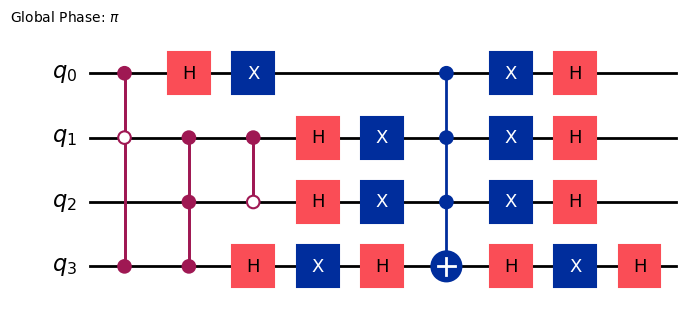

In [13]:

from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.circuit.library import grover_operator

expression = '(w | x) & (~y | z) & (x | y | z)'

oracle = PhaseOracle(expression)
state_preparation = QuantumCircuit(4)
state_preparation.x(0)  # Apply an X gate to the first qubit to set it to 1
grover_op = grover_operator(oracle)
grover_op.draw("mpl")


Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>
Success!
Top measurement: 11


/tmp/ipykernel_3103/3021384792.py:22: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


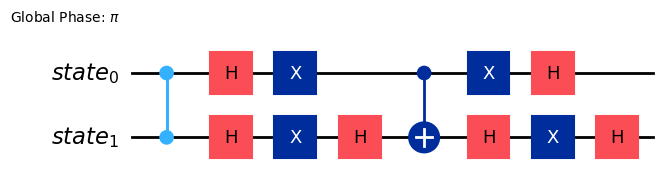

In [20]:
from qiskit import QuantumCircuit
from qiskit_algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ["11"]

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to appear in composition as a block
# so we have to decompose() the op to see it expanded into 
problem.grover_operator.decompose().draw(output="mpl")

from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)
problem.grover_operator.decompose().draw(output="mpl")


#### Rularea algoritmului Grover pe un backend simulat

Attempting to solve 'tests/test_unit.cnf'...
  Algorithm finished in 0.0099 seconds.
  Plotting results...


/tmp/ipykernel_3103/2184731702.py:25: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


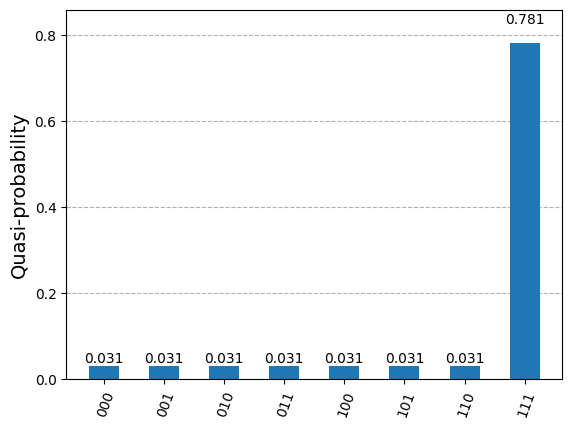

    - Bitstring: 111 (Probability: 0.7812)
{'111': np.float64(0.7812499999999983)}

Run complete.


In [21]:
import os
import time
from qiskit.circuit.library import PhaseOracle
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


def solve_dimacs_with_grover(filepath):
    """
    Solves a SAT problem from a DIMACS CNF file using Grover's algorithm.
    """
    
    # Create the oracle
    try:
        oracle = PhaseOracle.from_dimacs_file(filepath)
    except Exception as e:
        print(f"  Error creating oracle: {e}")
        return

    # Define the amplification problem for Grover's algorithm
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

    grover = Grover(sampler=Sampler())

    start_time = time.time()
    result = grover.amplify(problem)
    end_time = time.time()
    duration = end_time - start_time
    print(f"  Algorithm finished in {duration:.4f} seconds.")
    
    print("  Plotting results...")
    # The circuit_results attribute contains the data from the sampler.
    # We plot the first (and only) result from the list.
    if result.circuit_results:
        display(plot_histogram(result.circuit_results[0]))
    else:
        print("  No circuit results to plot.")
    # if the result is very close to the top measurement, we can consider it as a potential solution
    sorted_results = sorted(result.circuit_results[0].items(), key=lambda item: item[1], reverse=True)
    top_measurement = round(sorted_results[0][1], 2) if sorted_results else None

    filtered_results = {
                k: v for k, v in sorted_results if round(v, 2) == top_measurement
            }
    for bitstring, probability in filtered_results.items():
        print(f"    - Bitstring: {bitstring} (Probability: {probability:.4f})")
    print(filtered_results)

# Specify the single DIMACS file you want to solve
target_file = 'tests/test_unit.cnf' 

print(f"Attempting to solve '{target_file}'...")

if os.path.exists(target_file):
    solve_dimacs_with_grover(target_file)
else:
    print(f"Error: File '{target_file}' not found.")

print("\nRun complete.")

#### Rularea algoritmului Grover pe un backend de pe cloud-ul ibm

Attempting to solve 'tests/test_unit.cnf'...
  Ideal circuit depth: 4, Ops: OrderedDict([('h', 3), ('measure', 3), ('Q', 2)])
  (For analysis, constructing a sample circuit with 2 Grover iteration(s))
  Transpiling circuit for 'ibm_brisbane'...
  Transpiled (ISA) circuit depth: 165, Ops: OrderedDict([('rz', 121), ('sx', 71), ('ecr', 39), ('x', 11), ('measure', 3)])
  Job finished in 2.2560 seconds.
  Job finished in 2.2560 seconds.


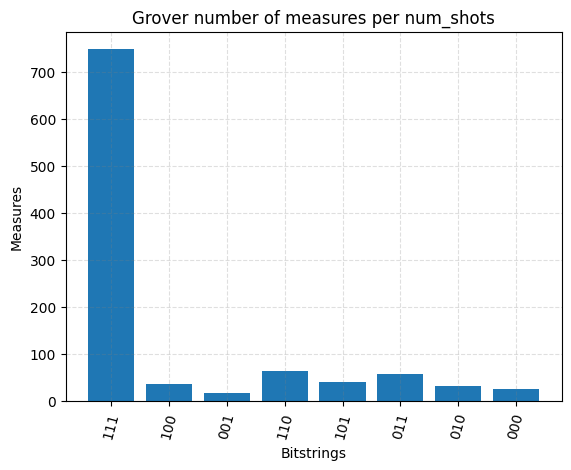

In [38]:
import os
import time
from qiskit.circuit.library import PhaseOracle
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit.transpiler import generate_preset_pass_manager
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# --- Function to solve a single DIMACS file ---
def solve_dimacs_with_grover(filepath):
    """
    Solves a SAT problem from a DIMACS CNF file using Grover's algorithm.
    """
    # print(f"--- Solving: {os.path.basename(filepath)} ---")

    # Create the oracle from the DIMACS file
    try:
        oracle = PhaseOracle.from_dimacs_file(filepath)
    except Exception as e:
        print(f"  Error creating oracle: {e}")
        return

    # Define the amplification problem for Grover's algorithm
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

    
    power = 2 # the number of iterations
    grover_op = Grover()
    circuit = grover_op.construct_circuit(problem, power=power, measurement=True)
    print(f"  Ideal circuit depth: {circuit.depth()}, Ops: {circuit.count_ops()}")

    print(f"  (For analysis, constructing a sample circuit with {power} Grover iteration(s))")
    
    print(f"  Transpiling circuit for '{backend.name}'...")
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    isa_circuit = pm.run(circuit)
    print(f"  Transpiled (ISA) circuit depth: {isa_circuit.depth()}, Ops: {isa_circuit.count_ops()}")


    start_time = time.time()
    job = sampler.run([isa_circuit])
    result = job.result()
    end_time = time.time()
    duration = end_time - start_time
    print(f"  Job finished in {duration:.4f} seconds.")


    pub_result = result[0]
    counts_data = pub_result.data
    bitarray = next(iter(counts_data.values()))
    plot_data = bitarray.get_counts()

    bitstrings = list(plot_data.keys())
    counts_values = list(plot_data.values())

    fig, ax = plt.subplots()

    ax.bar(bitstrings, counts_values)

    ax.set_title("Grover number of measures per num_shots")
    
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Measures")


    plt.xticks(rotation=75)


    ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)


    plt.show()

# Specify the single DIMACS file you want to solve
target_file = 'tests/test_unit.cnf' 

print(f"Attempting to solve '{target_file}'...")

if os.path.exists(target_file):
    solve_dimacs_with_grover(target_file)
else:
    print(f"Error: File '{target_file}' not found.")
